# Boston house-pricesデータで線形回帰を行う
目的：線形回帰で特徴量から住宅価格の予測を行う．

- cross validationのやり方を理解する
- L2正則化・L1正則化の特徴を理解する

In [23]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

np.random.seed(42)

## データ読み込み

In [24]:
# データ読込
data_train = pd.read_csv('C:/Users/t_toyofuku/jupyter_notebook/datasets/boston_train.csv', encoding="utf-8") #訓練用データ
data_test = pd.read_csv('C:/Users/t_toyofuku/jupyter_notebook/datasets/boston_test.csv', encoding="utf-8") #テスト用データ
#data_trainの最初の5行を表示してください。説明変数は13個，最後の列が目的変数の住宅価格("PRICE")
data_train.loc[:4]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,12.04820,0.0,18.10,0.0,0.614,5.648,87.6,1.9512,24.0,666.0,20.2,291.55,14.10,20.8
1,0.09604,40.0,6.41,0.0,0.447,6.854,42.8,4.2673,4.0,254.0,17.6,396.90,2.98,32.0
2,0.13960,0.0,8.56,0.0,0.520,6.167,90.0,2.4210,5.0,384.0,20.9,392.69,12.33,20.1
3,0.97617,0.0,21.89,0.0,0.624,5.757,98.4,2.3460,4.0,437.0,21.2,262.76,17.31,15.6
4,2.63548,0.0,9.90,0.0,0.544,4.973,37.8,2.5194,4.0,304.0,18.4,350.45,12.64,16.1


## 正則化なしで学習

In [25]:
transformer = StandardScaler() # 各データを平均0，分散1に標準化するtransformer
X_train =  transformer.fit_transform(data_train.iloc[:, :-1].values) # 目的変数以外の全ての特徴量を使う
y_train = data_train["PRICE"].values # 目的変数は"PRICE"

regr = LinearRegression() # 線形回帰モデル
regr.fit(X_train, y_train) #全データでtraining
print("learned_weights: \n{}\n".format(regr.coef_)) #学習したweight
print("learned_weights_norm: \n{}".format(np.linalg.norm(regr.coef_))) #学習したweightのノルム

learned_weights: 
[-1.9938318  -0.00514514 -1.06877296  0.19316485 -0.27029444  4.18281932
 -0.38174363 -2.06176461  2.88382851 -1.98832444 -2.56023851 -0.4912957
 -1.51583418]

learned_weights_norm: 
6.96307870288446


### 学習したモデルでテストデータに対する性能を評価

In [27]:
X_test = transformer.transform(data_test.iloc[:, :-1].values) #transformerは訓練データと同じものを用いる
y_test = data_test["PRICE"].values
y_pred = regr.predict(X_test)
print("RMSE: {}".format(mean_squared_error(y_test, y_pred,))) #平均二乗誤差(RMSE)を評価
print("R2: {}".format(r2_score(y_test, y_pred))) #決定係数(R2 score)を評価

RMSE: 29.97417335201148
R2: 0.6504972374818303


## L2正則化を用いて学習

- L2正則化により過学習が抑えられる
- 正則化なしの時よりも未知データに対する性能が上がることを期待

### cross validationで最適な正則化係数を求める

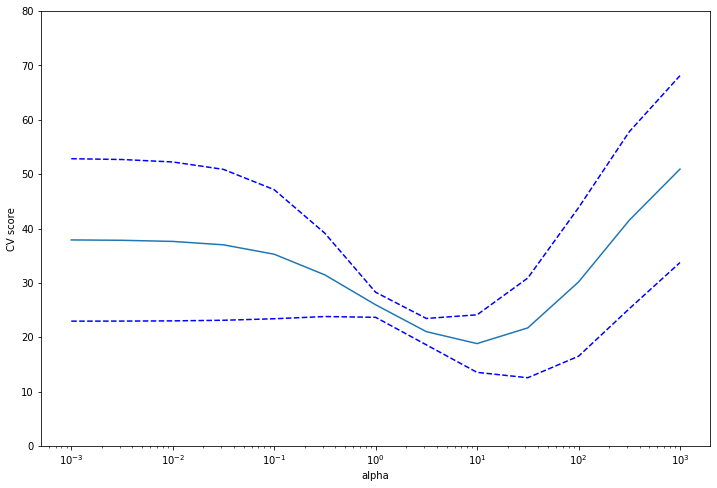

Optimal alpha: 10.0


In [28]:
alpha_s = np.logspace(-3, 3, 13) #今回試す正則化係数alphaの候補
scores_l2 = [] #各alphaにおけるCV時のRMSEを格納するリスト
scores_std_l2 = [] #各alphaにおけるCV時のRMSEの標準偏差を格納するリスト
regr_l2 = Ridge() #リッジ回帰(L2正則化線形回帰)のインスタンス

#CVにより最適なalphaを決定する
for alpha in alpha_s:
    regr_l2.alpha = alpha
    #分割数3,評価指標neg_mean_squared_errorでcross_val_scoreを算出
    scores = cross_val_score(regr_l2, X_train, y_train, scoring="neg_mean_squared_error", cv=3)
    scores_l2.append(-np.mean(scores))
    scores_std_l2.append(np.std(scores))

#各alphaのCV scoreをプロット
plt.figure(figsize=(12, 8))
plt.semilogx(alpha_s, scores_l2) #scoreの平均
plt.semilogx(alpha_s, np.array(scores_l2) + np.array(scores_std_l2), 'b--') #scoreの標準偏差のバンド
plt.semilogx(alpha_s, np.array(scores_l2) - np.array(scores_std_l2), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.show()

opt_alpha_l2 = alpha_s[np.argmin(scores_l2)]
print("Optimal alpha: {}".format(opt_alpha_l2))

### 最適な正則化係数で学習

In [29]:
#先ほど選択した一番いい正則化パラメータのリッジ回帰インスタンスを作成
regr_l2.alpha = opt_alpha_l2
regr_l2.fit(X_train, y_train) #最適なalphaと全てのデータでtraining
print("learned_weights: \n{}\n".format(regr_l2.coef_)) #学習したweight
print("learned_weights_norm: \n{}".format(np.linalg.norm(regr_l2.coef_))) #学習したweightのノルム

learned_weights: 
[-0.78370285  0.19675859 -1.10824033  0.45251611  0.15956077  3.32710975
 -0.07815427 -1.12990077  0.65389434 -0.88600045 -1.93149897 -0.08036112
 -1.80878294]

learned_weights_norm: 
4.762897315370583


正則化なしの場合よりもweightのノルムが小さくなっている．

### 学習したモデルでテストデータに対する性能を評価

In [30]:
#テストデータでの予測
y_pred_l2 = regr_l2.predict(X_test)
print("RMSE: {}".format(mean_squared_error( y_test, y_pred_l2)))
print("R2: {}".format(r2_score(y_test, y_pred_l2))) 

RMSE: 20.662570537249312
R2: 0.7590717382365925


正則化なしの場合よりも予測精度がよくなっていることが確認できる．

## L1正則化(LASSO)を用いて学習・特徴選択を行う
- 正則化により過学習を抑える
- L2正則化よりも学習後の重みが0になりやすい -> 目的変数への寄与が大きい特徴を選択することができる

### cross validationで最適な正則化係数を求める

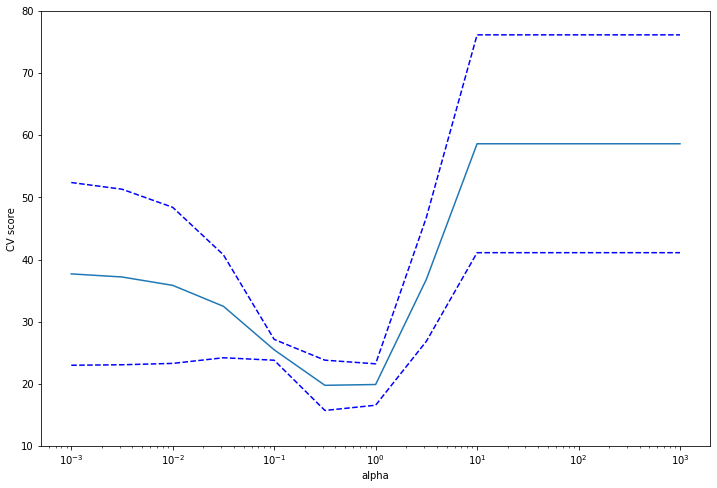

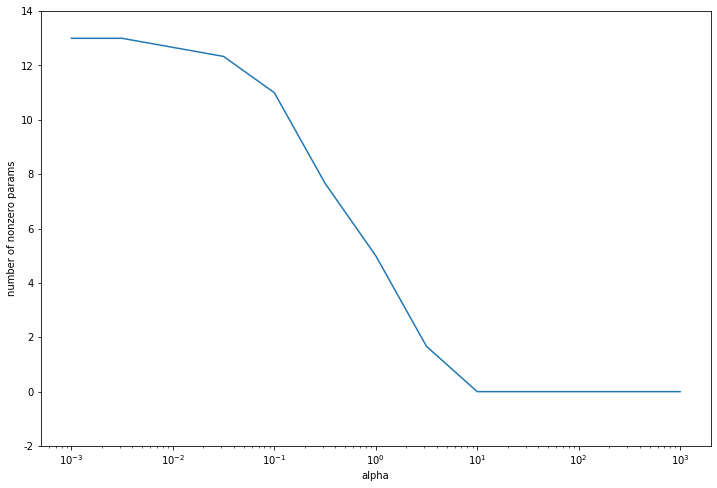

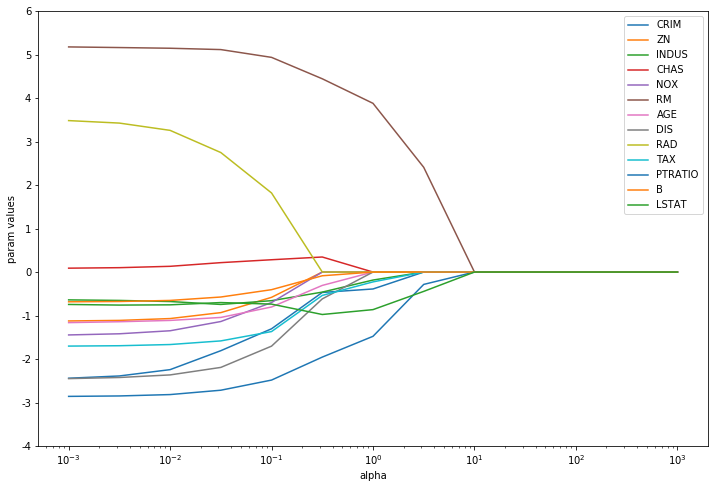

Optimal alpha: 0.31622776601683794


In [31]:
alpha_s = np.logspace(-3, 3, 13) #今回試す正則化係数alphaの候補
scores_l1 = [] #各alphaにおけるCV時のRMSEの平均を格納するリスト
scores_std_l1 = [] #各alphaにおけるCV時のRMSEの標準偏差を格納するリスト
nonzero_counts = [] #各alphaにおけるCV時の非ゼロパラメータの数の平均を格納するリスト
coefs = [] #各alphaにおけるCV時のパラメータの平均を格納するリスト
regr_l1 = Lasso() #LASSO回帰(L1正則化線形回帰)のインスタンス

#CVにより最適なalphaを決定する
for alpha in alpha_s:
    regr_l1.alpha = alpha
    scores = cross_validate(regr_l1, X_train, y_train, scoring=("neg_mean_squared_error"), cv=3, return_estimator=True) #各CVで訓練したモデルを利用するため，cross_validate関数を使う
    scores_l1.append(-np.mean(scores["test_score"]))
    scores_std_l1.append(np.std(scores["test_score"]))
    nonzero_counts.append(np.mean([np.count_nonzero(regr.coef_) for regr in scores["estimator"]])) #各モデルの非ゼロパラメータ数の平均
    coefs.append(np.mean([regr.coef_ for regr in scores["estimator"]], axis=0)) #各モデルのパラメータの値の平均

#各alphaのCV scoreをプロット
plt.figure(figsize=(12, 8))
plt.semilogx(alpha_s, scores_l1) #scoreの平均
plt.semilogx(alpha_s, np.array(scores_l1) + np.array(scores_std_l1), 'b--') #scoreの標準偏差のバンド
plt.semilogx(alpha_s, np.array(scores_l1) - np.array(scores_std_l1), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.show()

#各alphaの平均非ゼロパラメータ数をプロット
plt.figure(figsize=(12, 8))
plt.semilogx(alpha_s, nonzero_counts)
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('number of nonzero params')
plt.xlabel('alpha')
plt.show()

#各alphaの平均非ゼロパラメータ数をプロット
plt.figure(figsize=(12, 8))
for i, coef in enumerate(np.array(coefs).T):
    plt.semilogx(alpha_s, coef, label=data_train.columns[i])
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('param values')
plt.xlabel('alpha')
plt.legend(loc='upper right')
plt.show()

opt_alpha_l1 = alpha_s[np.argmin(scores_l1)] #CV scoreが一番良かったalpha
print("Optimal alpha: {}".format(opt_alpha_l1))

### 最適な正則化係数で学習

In [32]:
#リッジ回帰の時を参考に、先ほど求めた最適な正則化パラメータで学習し、学習したweightを出力してください。
regr_l1.alpha = opt_alpha_l1
regr_l1.fit(X_train, y_train) #最適なalphaと全てのデータでtraining
print("selected variables: \n{}\n".format(data_train.columns.values[:-1][regr_l1.coef_ != 0])) #選択された特徴名
print("learned_weights: \n{}\n".format(regr_l1.coef_)) #学習したweight

selected variables: 
['CRIM' 'INDUS' 'CHAS' 'RM' 'DIS' 'TAX' 'PTRATIO' 'LSTAT']

learned_weights: 
[-0.54673067 -0.         -0.4825673   0.29923629 -0.          4.1507294
 -0.         -0.56938927  0.         -0.46423672 -2.01496713 -0.
 -1.37793676]



weightがスパースになっている，つまり重要な特徴が選択できている．

### 学習したモデルでテストデータに対する性能を評価

In [35]:
#リッジ回帰の時を参考に、テストデータで予測を行い、平均二乗誤差と決定係数を出力してください。
X_test = transformer.transform(data_test.iloc[:, :-1].values) #transformerは訓練データと同じものを用いる
y_test = data_test["PRICE"].values
y_pred_l1 = regr_l1.predict(X_test)
print("RMSE: {}".format(mean_squared_error(y_test, y_pred,))) #平均二乗誤差(RMSE)を評価
print("R2: {}".format(r2_score(y_test, y_pred))) #決定係数(R2 score)を評価

RMSE: 29.97417335201148
R2: 0.6504972374818303


こちらも正則化なしの場合よりも予測精度がよくなっていることが確認できる．

## 正則化方法を変えた時の予測の様子

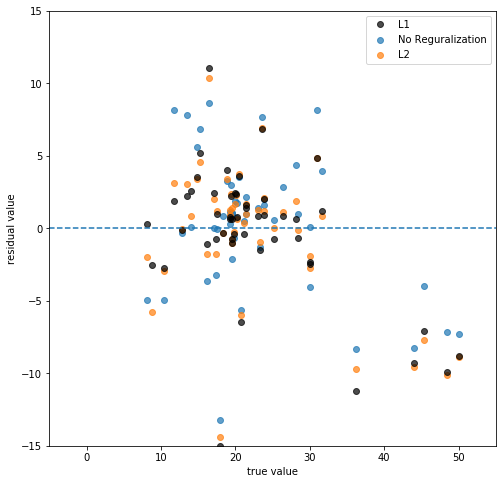

In [36]:
#真の値と残差の対応をプロット
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred - y_test, label="No Reguralization", alpha=0.7)
plt.scatter(y_test, y_pred_l2 - y_test, label="L2", alpha=0.7)
#plt.scatter(y_test, y_pred_l1 - y_test, label="L1", alpha=0.7)
plt.plot(y_test, y_pred_l1 - y_test, 'ok', label="L1", alpha=0.7) # plotのフォーマットでも散布図を描ける．
plt.plot([-5, 55], [0, 0], linestyle='--') 
plt.xlabel("true value")
plt.ylabel("residual value")
plt.xlim(-5, 55)
plt.ylim(-15, 15)
plt.legend()
plt.show()

値が大きいデータに対する残差は，正則化なしの場合が比較的小さいが，そうではないデータに対しては正則化をつけたほうが残差は小さい．